# BertonGan MNIST experiments

### Overview

This notebook will take you through the following using the MNIST dataset:

- loading in the MNIST dataset
- instantiating BertonGan + what a BeronGan is
- training a BertonGan + how the training procedure works
- using a BertonGan for inference
- using a BertonGan for style transfer

In [7]:
# setup our environment to work with colab (if we are using it)

import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
	!git clone https://github.com/Herb-Wright/berton-gan/
	!mv berton-gan berton_gan
	import os
	sys.path.append(os.path.abspath('berton_gan'))

import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Loading in the MNIST dataset

And displaying the first $K$ images

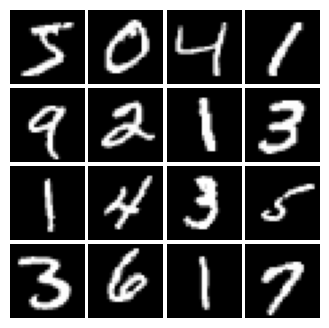

In [11]:
from src import download_mnist_data
from experiments import show_images

# this is how we download mnist data
training_data = download_mnist_data()
testing_data = download_mnist_data(train=False)

# display first K images
K = 25

show_images([training_data[i][0] for i in range(K)], grayscale=True)


## Creating the 'mnist' BertonGan

A BertonGan has five different networks:

- face encoder ($f_F: \mathbb R^{d} \rightarrow \mathbb R^{H_F}$): takes in $n$ images of class $A$ ($F_A \in \mathbb R^{n \times d}$) and returns a latent vector $h_F \in \mathbb R^{H_F}$ by average pooling each image's corresponding latent vector
- image encoder ($f_I: \mathbb R^d \rightarrow \mathbb R^{H_I}$): takes in $N$ images of any class and returns $N$ latent representations of the image.
- image decoder
- discriminator1
- discriminator2

### Constructing our BertonGan

Next, we must make our BertonGan, and store it in a variable

In [4]:
from src import BertonGan

# we make our BertonGan! (and put on device)
berton_gan = BertonGan('mnist')

print(berton_gan.face_encoder)
print(berton_gan.image_encoder)
print(berton_gan.image_decoder)
print(berton_gan.discriminator1)
print(berton_gan.discriminator2)

TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of SymInts size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


## Training our BertonGan on MNIST

training a BertonGan takes a long time and careful adjustments, so it is unlikely yours will turn out that good in only 10 epochs

### Training the BertonGan

Next, we train our BertonGan!

In [13]:
from src import train_all_at_once, MnistLoader

# set to false to not train the gan
TRAIN_BERTONGAN = True

if TRAIN_BERTONGAN:
	# here we train our berton_gan
	n, N, learning_rate, epochs = 3, 32, 1e-2, 10
	dataloader = MnistLoader(3, 32)
	train_all_at_once(berton_gan, dataloader, epochs, optimizer_options={'lr': learning_rate}, verbose=True)


### Loading in berton_gan from file

In [ ]:
from experiments.utils import load_berton_gan

if not TRAIN_BERTONGAN:
	berton_gan = load_berton_gan('mnist_experiment_herb_8/49')

## Using BertonGan for inference

The process for using BertonGan for inference is:

1. loop through training data and find average latent vectors for each class (digits 1-10)
   - in our code, we approximate this with a number of random indexes of the training data instead of the whole thing
2. loop through testing data and classify each test image with the following:
   1. calculating scores by running discriminator2 on the image for each latent encoding
   2. class corresponding to latent encoding with highest score is the prediction

The pretrained model should achieve about $97$% accuracy.

In [ ]:
from tqdm import tqdm, trange

# set berton_gan to eval mode
berton_gan.eval()

# build our latent vectors
N = 5000 # we approximate our training data with N random samples for speed purposes
idxs = torch.randint(0, len(training_data), (N, 1))
style_encodings = torch.zeros((10, 2), device=DEVICE)
counts = torch.zeros((10,), device=DEVICE)
for i in trange(
	N,
	desc='computing latent vectors for training data'
):
	x_i, y_i = training_data[idxs[i].squeeze()]
	x_i = x_i.to(DEVICE)
	counts[y_i] += 1
	style_encodings[y_i] += berton_gan.face_encoder(x_i.unsqueeze(0)).squeeze()
style_encodings /= counts.unsqueeze(1)

print(f'our latent encodings are {style_encodings}')

# go through test set and see accuracy
correct, total = 0, 0
for i in trange(
	len(testing_data),
	desc='evaluating on test data'
):
	x_i, y_i = testing_data[i]
	x_i = x_i.to(DEVICE)
	total += 1
	scores = torch.zeros(10, device=DEVICE)
	for i in range(10):
		scores[i] = berton_gan.shares_style_latent(x_i, style_encodings[i])
	if torch.argmax(scores) == y_i:
		correct += 1

# print our result
print(f'The BertonGan acheived {correct / total} accuracy on test data')

## Using BertonGan for style transfer

We conduct style transfer by inputting our style image into the face encoder network, and inputting our content image into the image encoder, then passing our latent embeddings into our image decoder network.

In the output of the code before the order of the images is [content] + [style] = [result]. The style and result should have the same number, and the content and result image should be close in l2 distance. 

In [ ]:
from random import randint

berton_gan.eval()

imgs = []
for i in range(12):
	# pick a content image
	content_img, _ = testing_data[randint(0, len(testing_data))]
	imgs.append(content_img)

	# pick a style image
	style_img, _ = testing_data[randint(0, len(testing_data))]
	imgs.append(style_img)

	# generate new image
	new_img = berton_gan.generate_image(style_img.to(DEVICE), content_img.to(DEVICE))
	imgs.append(new_img)

print(f'columns 1 and 4 are content; columns 2 and 5 are style; columns 3 and 6 are result')
show_images(imgs, grayscale=True)